In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import utils
from bs4 import BeautifulSoup

import nltk

In [27]:
products = pd.read_csv('data/DreamMarket_master_product.csv')

C:\Users\morga\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


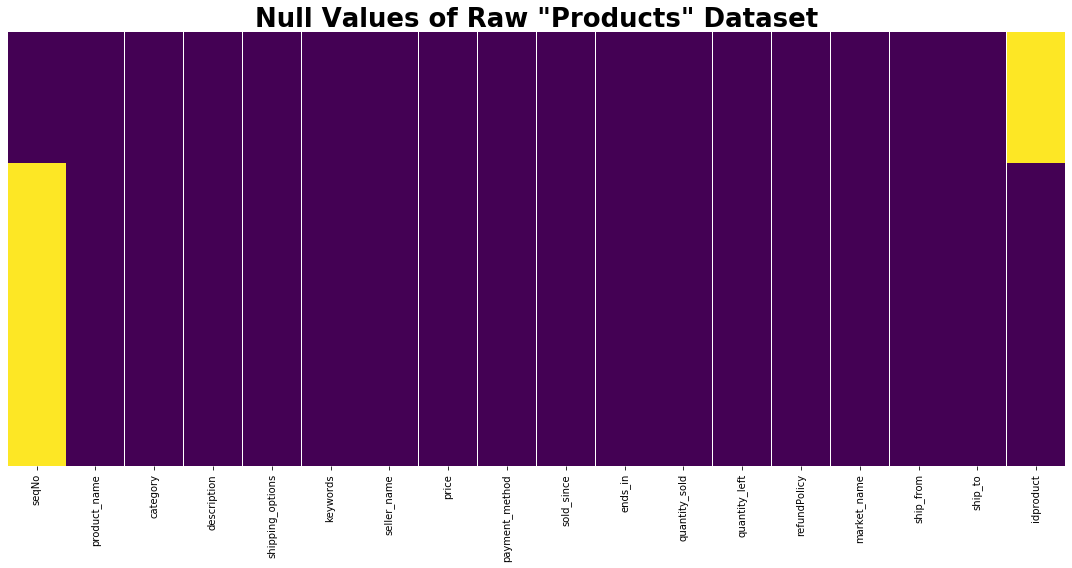

In [31]:
utils.plot_null_val_heatmap(products, 'Null Values of Raw "Products" Dataset', (15,8))

## Reference Objects

In [30]:
country_map = {'united states': 'usa', 'united kingdom' :'uk', 'dutch': 'netherlands', 'ww': 'worldwide', 'holland': 'netherlands', 'amsterdam': 'netherlands', 'nederland': 'netherlands',
              'españa': 'spain', 'au': 'australia', 'deutschland': 'germany'}

## Functions - Add to utils.py

## Review Raw Data

In [32]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130936 entries, 0 to 130935
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   seqNo             39473 non-null   float64
 1   product_name      130936 non-null  object 
 2   category          130936 non-null  object 
 3   description       130936 non-null  object 
 4   shipping_options  130936 non-null  object 
 5   keywords          130936 non-null  object 
 6   seller_name       130936 non-null  object 
 7   price             130936 non-null  object 
 8   payment_method    130936 non-null  object 
 9   sold_since        130936 non-null  object 
 10  ends_in           130936 non-null  object 
 11  quantity_sold     130936 non-null  object 
 12  quantity_left     130936 non-null  object 
 13  refundPolicy      130936 non-null  object 
 14  market_name       130936 non-null  object 
 15  ship_from         130932 non-null  object 
 16  ship_to           13

In [33]:
cols_to_review = ['sold_since', 'ends_in', 'quantity_sold', 'quantity_left', 'refundPolicy', 'keywords', 'market_name']
for x in cols_to_review:
    print('{}: {}'.format(x, products[x].unique()))

sold_since: ['-']
ends_in: ['-']
quantity_sold: ['-']
quantity_left: ['-']
refundPolicy: ['-']
keywords: ['-']
market_name: ['Dream']


## Text Cleaning

In [34]:
products_v2 = products.drop(cols_to_review, axis=1)

In [42]:
# Create sale year of posting
products_v2['is_2016'] = products_v2['idproduct'].isnull()
products_v2['year_posted'] = products_v2['is_2016'].apply(lambda x: 2016 if x == True else 2017)
products_v2.drop('is_2016', axis=1, inplace=True)

# Convert listing price from string to float.
products_v2['adj_price'] = products_v2['price'].apply(lambda x: utils.convert_price_to_float(x))

In [43]:
# Create master product id
num_ints_for_product_id = 6
products_v2['merged_id'] = products_v2.apply(lambda x: utils.select_non_null_value(x['seqNo'], x['idproduct']), axis=1)
products_v2['master_product_id'] = products_v2.apply(lambda x: utils.create_product_id(x['merged_id'], num_ints_for_product_id, x['year_posted']), axis=1)

id_drop_cols = ['seqNo', 'idproduct', 'merged_id']
products_v2.drop(id_drop_cols, axis=1, inplace=True)

In [44]:
# Seperate category name and ID.
products_v2['category_revised'] = products_v2['category'].str.replace(r'\n', '')
products_v2['category_revised'] = products_v2['category_revised'].str.replace('\t', '')
products_v2['category_name'] = products_v2['category_revised'].str.findall(r'[a-zA-Z ]')
products_v2['category_name'] = products_v2['category_name'].apply(lambda x: ''.join(x))
products_v2['category_name'] = products_v2['category_name'].apply(lambda x: utils.replace_empty_cell_with_nan(x))


products_v2['category_id'] = products_v2['category_revised'].str.findall(r'[\d+ ]')
products_v2['category_id'] = products_v2['category_id'].apply(lambda x: ''.join(x))
products_v2['category_id'] = products_v2['category_id'].apply(lambda x: utils.replace_empty_cell_with_nan(x))

products_v2.drop(['category', 'category_revised'], axis=1, inplace=True)

---
## Extract Info From Product Name

**Regex Examples:**
```
df['method_1'] = df['text'].str.findall(r'\d{1,2}[/-]\d{1,2}[/-]\d{2,4}')
df['method_2'] = df['text'].str.findall(r'(\d{1,2}) (Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]* (\d{2,4})')
df['method_3'] = df['text'].str.findall(r'(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*[.]* (\d{1,2})[,]* (\d{2,4})')
df['method_4'] = df['text'].str.findall(r'(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*[.,]* \d{4}')
df['method_5'] = df['text'].str.findall(r'\d{1,2}[/-]\d{4}')
df['method_6'] = df['text'].str.findall(r'\d{4}')
```    

In [45]:
products_v2['prod_name_arr'] = products_v2['product_name'].apply(lambda x: utils.clean_and_split_text(x, r"[^a-zA-Z0-9$%.@'/_]"," "))

In [46]:
products_v2.iloc[50000:50005, :]

,product_name,description,shipping_options,seller_name,price,payment_method,ship_from,ship_to,year_posted,adj_price,master_product_id,category_name,category_id,prod_name_arr
50000,Addison Wesley - Web Hacking A - attacks,Addison Wesley - Web Hacking A - attacks\n\n\n...,-,HappyEyes,1.0,Escrow Yes,Worldwide,Worldwide,2017,1.0,17-073184,Digital Goods Fraud,,"[Addison, Wesley, Web, Hacking, A, attacks]"
50001,Addison Wesley - Web Hacking A - attacks,Addison Wesley - Web Hacking A - attacks\n\n\n...,-,HappyEyes,1.0,Escrow Yes,Worldwide,Worldwide,2017,1.0,17-073185,Digital Goods Information eBooks,,"[Addison, Wesley, Web, Hacking, A, attacks]"
50002,Addison Wesley - Web Hacking A - attacks,Addison Wesley - Web Hacking A - attacks\n\n\n...,-,HappyEyes,1.0,Escrow Yes,Worldwide,Worldwide,2017,1.0,17-073186,Digital Goods,,"[Addison, Wesley, Web, Hacking, A, attacks]"
50003,Addison Wesley - Web Hacking A - attacks,Addison Wesley - Web Hacking A - attacks\n\n\n...,-,HappyEyes,1.0,Escrow Yes,Worldwide,Worldwide,2017,1.0,17-073187,Services Hacking,,"[Addison, Wesley, Web, Hacking, A, attacks]"
50004,Addison Wesley Professional.Honeypots - Tracki...,Addison Wesley Professional.Honeypots - Tracki...,-,HappyEyes,1.0,Escrow Yes,Worldwide,Worldwide,2017,1.0,17-073188,Digital Goods Fraud,,"[Addison, Wesley, Professional.Honeypots, Trac..."


---
## Extract Info From Description

In [47]:
products_v2['desc_arr'] = products_v2['description'].apply(lambda x: utils.clean_and_split_text(x, r"[^a-zA-Z0-9$%.'/_]"," "))

In [48]:
products_v2.iloc[50:58, :]

,product_name,description,shipping_options,seller_name,price,payment_method,ship_from,ship_to,year_posted,adj_price,master_product_id,category_name,category_id,prod_name_arr,desc_arr
50,5 gram pure SPEEDPASTE 72-74% PURITY - FREE SH...,5 gram pure SPEEDPASTE 72-74% PURITY - FREE SH...,\n\n\n$0\t\t\t\t\t\nexpress - track&trace - 2-...,DeLosMuertos,$269,Escrow Yes,Australia Europe,Australia Japan,2016,269.0,16-000051,Drugs,41788,"[5, gram, pure, SPEEDPASTE, 72, 74%, PURITY, F...","[5, gram, pure, SPEEDPASTE, 72, 74%, PURITY, F..."
51,LEMON HAZE 5 GRAM,Lemon Haze is a hybrid of Lemon Skunk and Amne...,\n\n\n$3.147\t\t\t\t\t\nPriority shipping West...,DutchDreams,$64,Escrow Yes,Netherlands,Europe,2016,64.0,16-000052,Drugs,41829,"[LEMON, HAZE, 5, GRAM, ]","[Lemon, Haze, is, a, hybrid, of, Lemon, Skunk,..."
52,Dream Market Login - Featured anonymous market...,-,-,-,-,-,-,-,2016,NaN,16-000053,NaN,NaN,"[Dream, Market, Login, Featured, anonymous, ma...","[, ]"
53,100gr FLAKES COCAINE 92% â¯GAâ¯,Gomorra Amsterdam Shop...,\n\n\n$4.74\t\t\t\t\t\nâ¯â¯Priorety Mailâ¯â...,gomorraamsterdam,$3585,Escrow No,EUROPE,Worldwide United States,2016,3585.0,16-000054,Drugs,41746,"[100gr, FLAKES, COCAINE, 92%, GA, ]","[, Gomorra, Amsterdam, Shop, WARNING, READ, OU..."
54,Dream Market Login - Featured anonymous market...,-,-,-,-,-,-,-,2016,NaN,16-000055,NaN,NaN,"[Dream, Market, Login, Featured, anonymous, ma...","[, ]"
55,Paypal Starter Package,This is a complete starter package that will h...,-,passman,$199.9,Escrow No,Worldwide,Worldwide Worldwide,2016,199.9,16-000056,Digital Goods,29364,"[Paypal, Starter, Package]","[This, is, a, complete, starter, package, that..."
56,503 - Forwarding failure (Privoxy@localhost),-,-,-,-,-,-,-,2016,NaN,16-000057,NaN,NaN,"[503, Forwarding, failure, Privoxy@localhost, ]","[, ]"
57,Dream Market Login - Featured anonymous market...,-,-,-,-,-,-,-,2016,NaN,16-000058,NaN,NaN,"[Dream, Market, Login, Featured, anonymous, ma...","[, ]"


--- 
## Extract Info From "Shipping Options"

In [49]:
products_v2['shipping_cleaned'] = products_v2['shipping_options'].apply(lambda x: utils.clean_and_split_text(x, r"[^a-zA-Z0-9$%.'/_]"," "))

In [50]:
products_v2.iloc[20:25, :]

,product_name,description,shipping_options,seller_name,price,payment_method,ship_from,ship_to,year_posted,adj_price,master_product_id,category_name,category_id,prod_name_arr,desc_arr,shipping_cleaned
20,â 15GR â The BEST Quality Cocaine,"Notice ""Constant Amazing quality is hard to ge...",\n\n\n$12.6\t\t\t\t\t\nDecoy Worldwide\n\n\n\n...,WarnerBos,$992,Escrow No,Europe,Worldwide,2016,992.0,16-000021,Drugs,40284,"[, 15GR, The, BEST, Quality, Cocaine]","[Notice, Constant, Amazing, quality, is, hard,...","[$12.6Decoy, Worldwide$33.6Track, Trace, Decoy..."
21,40gr FLAKES COCAINE 92% â¯GAâ¯,Gomorra Amsterdam Shop...,\n\n\n$4.74\t\t\t\t\t\nâ¯â¯Priorety Mailâ¯â...,gomorraamsterdam,$1687,Escrow No,EUROPE,Worldwide United States,2016,1687.0,16-000022,Drugs,41729,"[40gr, FLAKES, COCAINE, 92%, GA, ]","[, Gomorra, Amsterdam, Shop, WARNING, READ, OU...","[$4.74, Priorety, Mail, GA, ]"
22,250gr DUTCH SPEED PASTE AAA+ â¯GAâ¯,Gomorra Amsterdam Shop...,\n\n\n$4.74\t\t\t\t\t\nPRIORETY MAIL â¯GAâ¯\...,gomorraamsterdam,$474,Escrow No,Netherlands,Worldwide United States,2016,474.0,16-000023,Drugs,41729,"[250gr, DUTCH, SPEED, PASTE, AAA, GA, ]","[, Gomorra, Amsterdam, Shop, WARNING, READ, OU...","[$4.74PRIORETY, MAIL, GA, ]"
23,Dream Market Login - Featured anonymous market...,-,-,-,-,-,-,-,2016,NaN,16-000024,NaN,NaN,"[Dream, Market, Login, Featured, anonymous, ma...","[, ]","[, ]"
24,4 pill x Oxycontin 80mg ( PROMO DEAL ),Mundi Pharma\nOxycontin 80mg,\n\n\n$5.22\t\t\t\t\t\nWorld\n\n\n\n\n\n$3.129...,doctorH1,$104.4,Escrow Yes,Germany,Worldwide,2016,104.4,16-000025,Drugs,41731,"[4, pill, x, Oxycontin, 80mg, PROMO, DEAL, ]","[Mundi, PharmaOxycontin, 80mg, ]",[$5.22World$3.129Europe]


In [51]:
products_v2.shape

(130936, 16)

### Ship From Formatting

In [52]:
# NEED TO FINISH FUNCTION

def replace_uk_usa(text):
    try:
        text = re.sub(r'*united kingdom*', 'uk')
        text


def lowercase_and_split_string(text):
    '''
    
    
    '''
    
    if type(text) == str:
        text = text.lower()
        text = text.split(' ')

    return text

IndentationError: unexpected unindent (<ipython-input-52-29c2750e4cf0>, line 9)

In [ ]:
products_v2['ship_from_cleaned'] = products_v2['ship_from'].apply(lambda x: lowercase_and_split_string(x))

In [ ]:
ship_from_arr = []
for obs in products_v2['ship_from_cleaned']:
    if type(obs) == list:
        for l in obs:
            if l in country_map:
                ship_from_arr.append(country_map[l])
            else:
                ship_from_arr.append(l)
ship_from_arr = pd.Series(ship_from_arr)

In [ ]:
print('Length - Original : ', products_v2.shape[0])
print('# of Unique Values - Original', len(products_v2['ship_from'].unique()))

print('Length - Revised: ', len(ship_from_arr))
print('# of Unique Value - Original: ', len(ship_from_arr.unique()))

In [ ]:
ship_from_arr.value_counts()[:10]

In [ ]:
products_v2.head()

In [ ]:
products_v2.iloc[100100:100110, :]

## EDA

In [ ]:
utils.stats_summary(products_v2['adj_price'])

In [ ]:
plt.figure(figsize=(25,8))
less_than_100 = products_v2[products_v2['adj_price'] < 100]['adj_price']
sns.distplot(less_than_100)
plt.title('Price Distribution of Products Less Than 100', fontsize= 20);
print('# - Goods Less Than $100: ', len(less_than_100))
print('% - Total Good Less Than $100: {:.1%}'.format(len(less_than_100) / products.shape[0]))

In [ ]:
fig, ax = plt.subplots(figsize=(25,12))
ax = sns.countplot(x='category_name', data=products_v2)
ax.set_title('Distribution of Product Type', fontsize=22)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout();

---
# Vender Info

In [62]:
products16 = products_v2[products_v2['year_posted'] == 2016]
venders16 = pd.DataFrame(products16['seller_name'].value_counts())
venders16.columns = ['num_postings']

In [64]:
venders16.head(10)

,num_postings
-,13869
BANK,529
philobeto13,472
Cyberzen,426
color,420
debuyerking,413
OnePiece,403
HappyEyes,393
Doug-Heffernan,353
onenation,345


In [60]:
products17 = products_v2[products_v2['year_posted'] == 2017]
venders17 = pd.DataFrame(products17['seller_name'].value_counts())
venders17.columns = ['num_postings']

In [66]:
venders17.head(20)

,num_postings
pckabml,8147
HappyEyes,6598
color,2125
Cyberzen,1745
philobeto13,1596
TheShop,1330
OnePiece,1286
TopNotchMoneyMaker,1235
BANK,1212
Jigglypuff,1198
